# <center> **Dense Optical Flow** </center>

Dense optical flow attempts to compute the optical flow vector for every pixel of each frame. While such computation may be slower, it gives a more accurate result and a denser result suitable for applications such as learning structure from motion and video segmentation.

In [43]:
# Libraries
import numpy as np
import cv2
from scipy.signal import fftconvolve
from matplotlib import pyplot as plt

## **Image Gradient**

* Image is a matrix of pixel values representing various intensity level values.
* A pixel is the building block of an image.
* The gradient can be defined as the change in the direction of the intensity level of an image.

In [44]:
# Filters
# Sobel Filter
Sobel_filter_x = np.array([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]])

Sobel_filter_y =np.array([[ 1,  2,  1],
                          [ 0,  0,  0],
                          [-1, -2, -1]])

# Scharr Filter
Scharr_filter_x = np.array([[ -3, 0,  3],
                            [-10, 0, 10],
                            [ -3, 0,  3]])

Scharr_filter_y = np.array([[ 3, 10,  3],
                            [ 0, 0 ,  0],
                            [-3, 10, -3]])

# Prewitt Filter
Prewitt_filter_x = np.array([[1, 0, -1],
                             [1, 0, -1],
                             [1, 0, -1]])

Prewitt_filter_y = np.array([[ 1,  1,  1],
                             [ 0,  0,  0],
                             [-1, -1, -1]])

# Roberts Filter
Roberts_filter_x = np.array([[1,  0],
                             [0, -1]])

Roberts_filter_y = np.array([[ 0, 1],
                             [-1, 0]])

# Averaging Filter
Averaging_filter_x = np.array([[-0.25, 0.25],
                               [-0.25, 0.25]])

Averaging_filter_y = np.array([[-0.25, -0.25],
                               [ 0.25, 0.25]])

Averaging_filter_t = np.array([[0.25, 0.25],
                               [0.25, 0.25]])

In [45]:
def image_gradient(img, kernel_x, kernel_y):
    Ix = fftconvolve(in1=img, in2=kernel_x, mode='same')
    Iy = fftconvolve(in1=img, in2=kernel_y, mode='same')
    return Ix, Iy

def image_gradient2img(img1, img2, kernel_x, kernel_y, kernel_t):
    Ix = fftconvolve(in1=img1, in2=kernel_x, mode='same')
    Iy = fftconvolve(in1=img1, in2=kernel_y, mode='same')
    It = fftconvolve(in1=img1, in2=kernel_t, mode='same') + fftconvolve(in1=img2, in2=-kernel_t, mode='same')
    return Ix, Iy, It

# **Horn-Schunck method**

### **Horn-Schunck Function**

In [46]:
# Function: Horn-Schunck Optical Flow method
# PI: Previous image (np.ndarray)
# LI: Last image (np.ndarray)
# corner_list: List corners
# window_size: Window size (tuple)
# Return: vx, vy, corner_list
def Horn_Schunck_Optical_Flow(PI, LI, alpha, iter, window_size=(3, 3)):
    shape = np.shape(PI)

    # First Derivative in X, Y, XY direction
    Ix = Iy = It = np.zeros_like(PI)

    Ix[:, :-1] = (LI[:, 1:] - LI[:, :-1]) / 2.0
    Iy[:-1, :] = (LI[1:, :] - LI[:-1, :]) / 2.0
    It[:, :] = LI - PI

    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                           [1 / 6 , 0    , 1 / 6 ],
                           [1 / 12, 1 / 6, 1 / 12]], float)

    # Creating vx, vy
    vx = vy = np.zeros(shape)

    # Plot features
    for i in range(iter):
        vx_avg = cv2.blur(vx ** 2, window_size)
        vy_avg = cv2.blur(vy ** 2, window_size)
        err_val = ((Ix * vx_avg + Iy * vy_avg + It) / (alpha ** 2 + Ix ** 2 + Iy ** 2))
        vx = vx_avg - Ix * err_val
        vy = vy_avg - Iy * err_val

    return vx, vy

## **Plot image - Plot video**

In [47]:
# Function: Plot Optical Flow
# PI: Previous image (np.ndarray)
# LI: Last image (np.ndarray)
# vx: vx (np.ndarray)
# vy: vy (np.ndarray)
# fig_size: Figure size (tuple)
# threshold: Threshold
# Result: Plot vector on the previous image
def plot_image_optical_flow(PI, LI, vx, vy, fig_size=(10, 10), threshold=0.3):
    shape = np.shape(PI)

    # Create some random colors
    color = (0, 255, 0)
    fig = plt.figure()
    fig.set_figwidth(fig_size[0])
    fig.set_figheight(fig_size[1])

    # Plotting the vectors on the image
    plt.subplot(3, 1, 2)
    plt.title('Image 2')
    plt.imshow(LI)

    plt.subplot(3, 1, 3)
    plt.title('Plotting vector')
    plt.imshow(LI)

    for y in range(0, 2):
        for x in range(0, 2):
            if abs(vx[y][x]) > threshold or abs(vy[y][x]) > threshold: # setting the threshold to plot the vectors
                # cv2.circle(PI, (x, y), 3, color, -1)
                plt.arrow(x, y, vy[y][x], vx[y][x], head_width = 5, head_length = 5, color = 'g')
    
    plt.subplot(3, 1, 1)
    plt.title('Image 1')
    plt.imshow(PI)

In [48]:
# Function: Plot Optical Flow
# PI: Previous image (np.ndarray)
# LI: Last image (np.ndarray)
# vx: vx (np.ndarray)
# vy: vy (np.ndarray)
# fig_size: Figure size (tuple)
# threshold: Threshold
# Result: Plot vector on the previous image
def plot_video_optical_flow(frame, mask, vx, vy, threshold=0.3, title="image", color=(0, 255, 0)):
    shape = np.shape(frame)

    for y in range(0, shape[0] - 1):
        for x in range(0, shape[1] - 1):
            if abs(vx[y][x]) > threshold or abs(vy[y][x]) > threshold: # setting the threshold to plot the vectors
                # cv2.circle(frame, (x, y), 5, color[i].tolist(), -1)
                mask = cv2.line(mask, (x, y), (int(x + vx[y][x]), int(y + vy[y][x])), 
                                color = color, thickness = 3)
        
    img = cv2.add(frame, mask)
    cv2.imshow(title, img)
    return mask

### **Test Horn-Schunck function with two frames**

[[-6.45885009e+137 -3.24035630e+137  8.36466197e+133 ... -3.31828390e+129
  -6.07849374e+128 -1.09358373e+128]
 [-6.30579338e+136 -5.56279241e+138  4.78337218e+133 ...  7.53156840e+124
  -5.90181491e+128  1.72114912e+123]
 [ 2.78372152e+133  1.58635643e+133 -2.06746275e+138 ...  1.23242327e+123
   4.10807751e+122  8.21615489e+122]
 ...
 [-3.35970871e+130  7.12610704e+127  1.87142706e+128 ...  1.37590077e+129
   8.56749537e+123  4.76355855e+123]
 [-2.49249659e+130  5.75172719e+125  4.61725576e+127 ...  5.79321684e+126
   9.98840875e+126  1.17694014e+127]
 [ 1.33369012e+125  1.33432032e+125 -9.80115692e+129 ... -2.51130116e+131
  -4.32987490e+131 -5.10191781e+131]] [[-6.45885009e+137 -3.24035630e+137  8.36466197e+133 ... -3.31828390e+129
  -6.07849374e+128 -1.09358373e+128]
 [-6.30579338e+136 -5.56279241e+138  4.78337218e+133 ...  7.53156840e+124
  -5.90181491e+128  1.72114912e+123]
 [ 2.78372152e+133  1.58635643e+133 -2.06746275e+138 ...  1.23242327e+123
   4.10807751e+122  8.21615489e+

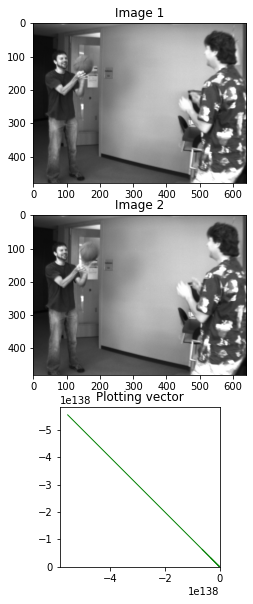

In [49]:
threshold = 0.3
window_size = (3, 3)
fig_size = (10, 10)

image1 = cv2.imread(r"image/basketball1.png")
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

image2 = cv2.imread(r"image/basketball2.png")
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

vx, vy = Horn_Schunck_Optical_Flow(PI          = gray_image1, 
                                   LI          = gray_image2,
                                   alpha       = 1.0        , 
                                   iter        = 5        , 
                                   window_size = window_size )

print(vx, vy)

plot_image_optical_flow(PI          = image1     , 
                        LI          = image2     , 
                        vx          = vx         , 
                        vy          = vy         , 
                        fig_size    = fig_size   , 
                        threshold   = threshold   )

### **Test Horn-Schunck function with video**

# **Compare to OpenCV**